In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import torch
import numpy as np
import pandas as pd
import json
import cv2
import random
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import torchvision

## Load images

In [20]:
# load images

lables_path = 'data/LDCTIQAG2023_train/train.json'
images_dir = 'data/LDCTIQAG2023_train/image'

def load_images(data):
    
    image_np = list()
    for name,val in data.items():
        img = cv2.imread(f'{images_dir}/{name}', cv2.IMREAD_UNCHANGED)
        image_np.append(img)
    return np.stack(image_np)

with open(lables_path) as file:
    all_lables = pd.Series(json.load(file))
    
all_images = load_images(all_lables)

In [21]:
class VornoiMaskGenerator:
    def __init__(self, shape):
        self.shape = shape
        extra_dist=1999
        self._extra_points = [[extra_dist,extra_dist],
                              [-extra_dist,extra_dist], 
                              [extra_dist,-extra_dist], 
                              [-extra_dist,-extra_dist]]
        
    def _make_mask(self, vor):
        polies = list()
        for reg in vor.regions:
            if -1 in reg or len(reg)<3:
                continue
            poly = np.array(vor.vertices)[reg].astype(np.int32)
            polies.append(cv2.fillPoly(np.zeros(self.shape), pts=[poly], color=1))

        return np.stack(polies)
    
    def __call__(self, sectors):
        xp = np.random.randint(0,self.shape[0],sectors)
        yp = np.random.randint(0,self.shape[1],sectors)
        all_points = np.append(np.stack([xp,yp]).T, self._extra_points, axis=0)
        vor = Voronoi(all_points)
        mask = self._make_mask(vor)
        
        assert mask.shape[0]==sectors, 'This class is shit make extra_dist more'
        return mask.astype(np.bool_)

In [22]:
class MosaicDS(torch.utils.data.IterableDataset):
    """Iterative dataset that returns mosaic of images with random lable"""
    
    def __init__(self, images: np.ndarray, lables: pd.Series, parts: int = 6):
        """Inintialiser.

        Keyword arguments:
        images -- np.ndarray with all n images of size x by x it should have shape (n, x, x)
        lables -- pd.Series where every entry has index of image name and value of lable
        parts -- number of images to combine for 1 mosaic
        """
        grouped = lables.reset_index().groupby(0).apply(lambda x: np.array(x.index))
        self.sz = len(images)
        self.images = {k:images[v] for k,v in grouped.items()}
        self.set_parts(parts)
        self.mask_generator = VornoiMaskGenerator(images[0].shape)
        
    def set_parts(self, parts: int):
        """Allows to change number of mosaic parts between epochs. 
        Dont forget recreate dataloader after using it.
        """
        for v in self.images.values():
            assert v.shape[0]>=parts, 'Some lables dont have enough parts'
        self.parts=parts
        
    def __iter__(self):
        return self.generator()
    
    def generator(self):
        for i in range(self.sz):
            lable = random.choice(list(self.images.keys()))
            susbset = self.images[lable]
            mask = np.zeros(susbset.shape[0],dtype=bool)
            mask[:self.parts] = 1
            np.random.shuffle(mask)
            image_parts = zip(susbset[mask], self.mask_generator(self.parts))
            img_res, _ = next(image_parts)
            for img, region in image_parts:
                img_res[region] = img[region] 
            yield lable, img_res

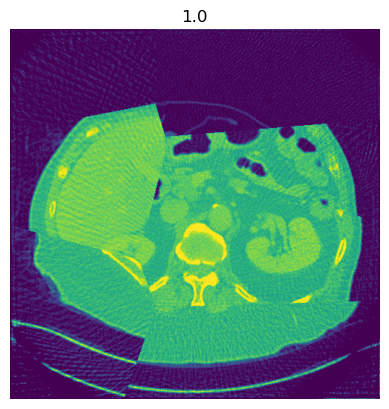

In [25]:
mds = MosaicDS(all_images, all_lables, 7)
lab, img = next(iter(mds))
ax = plt.subplot()
ax.imshow(img)
ax.set_title(lab)
ax.axis('off')
plt.show()

In [92]:
class VornoiDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, parts=6):
        assert len(images) == len(labels), 'Mismatch between number of images and labels.'
        self.images = images
        self.labels = labels
        self.parts = parts
        self.mask_generator = VornoiMaskGenerator((512, 512))

        self.grouped_images = {}
        for img, label in zip(images, labels):
            if label not in self.grouped_images:
                self.grouped_images[label] = []
            self.grouped_images[label].append(img)

    def __getitem__(self, index):
        label = self.labels[index]

        

        # Generate masks
        masks = self.mask_generator(self.parts)

        # Create composite image
        chosen_images = random.sample(self.grouped_images[label], masks.shape[0])

        image_parts = zip(chosen_images, masks)
        img_res, _ = next(image_parts)

        for img, mask in image_parts:
            img = np.array(img)
            img_res[mask] = img[mask]

            # Convert composite image to tensor
        transform = torchvision.transforms.ToTensor()
        img_composite = transform(img_res)

        label = torch.tensor(label).float()
        return img_composite, label

    def __len__(self):
        return len(self.images)


class VornoiMaskGenerator:
    def __init__(self, shape):
        self.shape = shape
        extra_dist = 3000
        self._extra_points = [[extra_dist, extra_dist],
                              [-extra_dist, extra_dist],
                              [extra_dist, -extra_dist],
                              [-extra_dist, -extra_dist]]

    def _make_mask(self, vor):
        polies = list()
        for reg in vor.regions:
            if -1 in reg or len(reg) < 3:
                continue
            poly = np.array(vor.vertices)[reg].astype(np.int32)
            polies.append(cv2.fillPoly(np.zeros(self.shape), pts=[poly], color=1))
        return np.stack(polies)

    def __call__(self, sectors):
        xp = np.random.randint(0, self.shape[0], sectors)
        yp = np.random.randint(0, self.shape[1], sectors)
        all_points = np.append(np.stack([xp, yp]).T, self._extra_points, axis=0)
        vor = scipy.spatial.Voronoi(all_points)
        mask = self._make_mask(vor)
        return mask.astype(np.bool_)

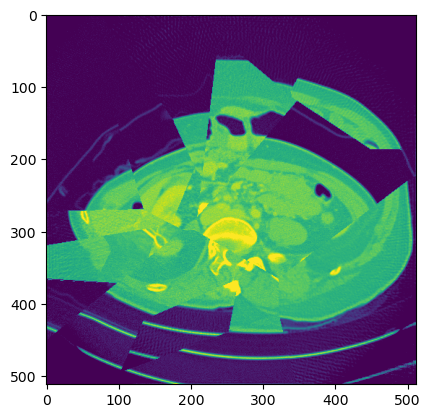

In [94]:
va = VornoiDataset(all_images, all_lables, 10)
tn, lb = next(iter(va))
plt.imshow(tn.numpy()[0])

In [47]:
tn.unique()

tensor([0.0000e+00, 5.6676e-07, 1.7439e-06,  ..., 9.9993e-01, 9.9996e-01,
        1.0000e+00])